In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)


In [36]:
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')

# Drop respondent_id from features and target labels
X = train_features.drop(columns=['respondent_id'])
y = train_labels.drop(columns=['respondent_id'])
X_test = test_features.drop(columns=['respondent_id'])

respondent_id = test_features['respondent_id']

Missing values in training set:
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
education                       1407
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
househ

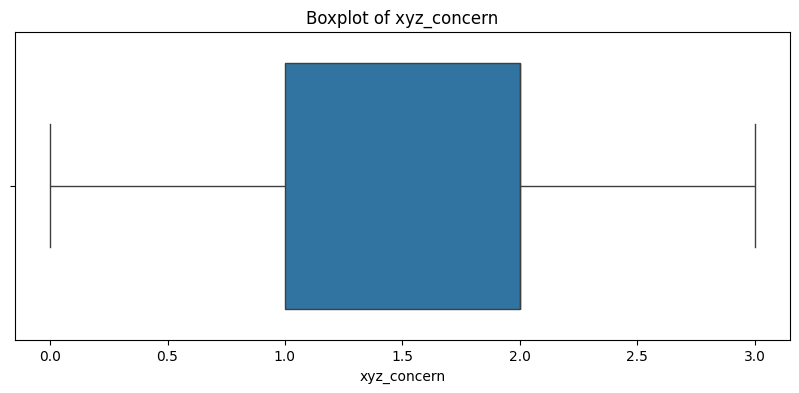

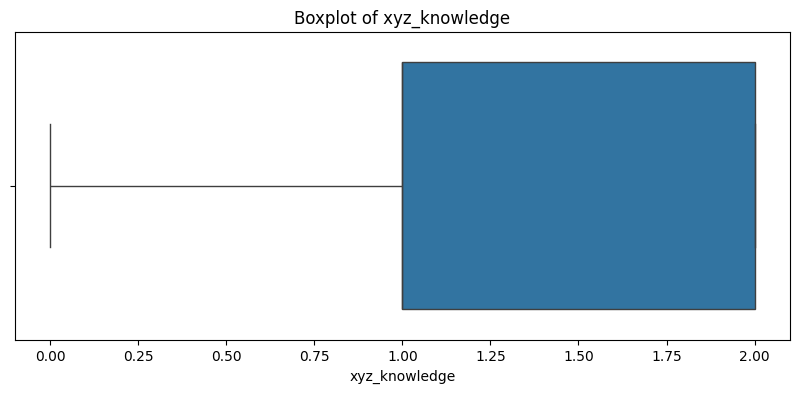

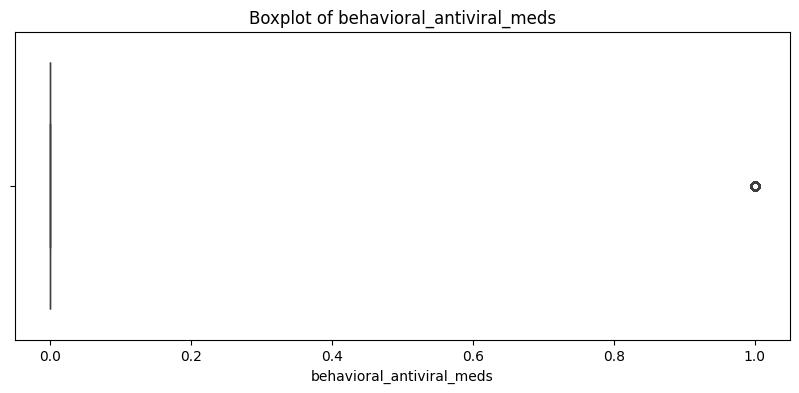

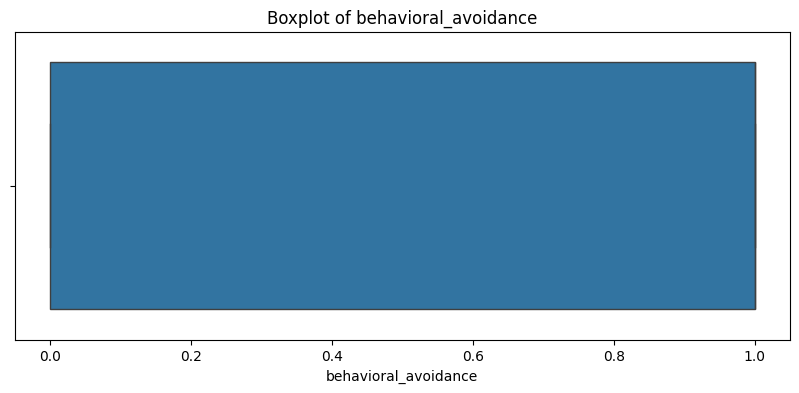

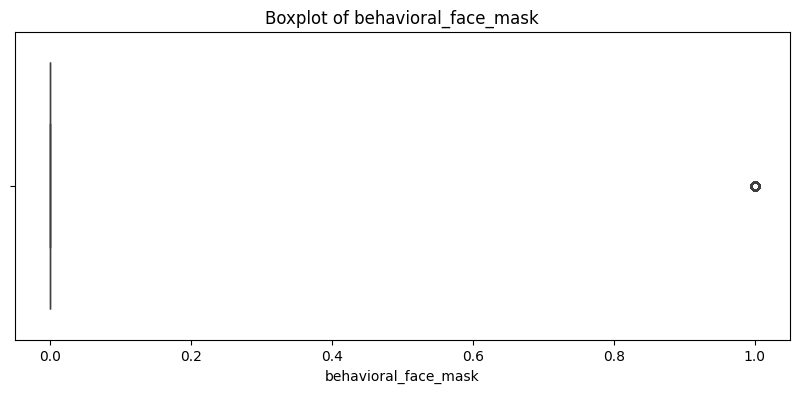

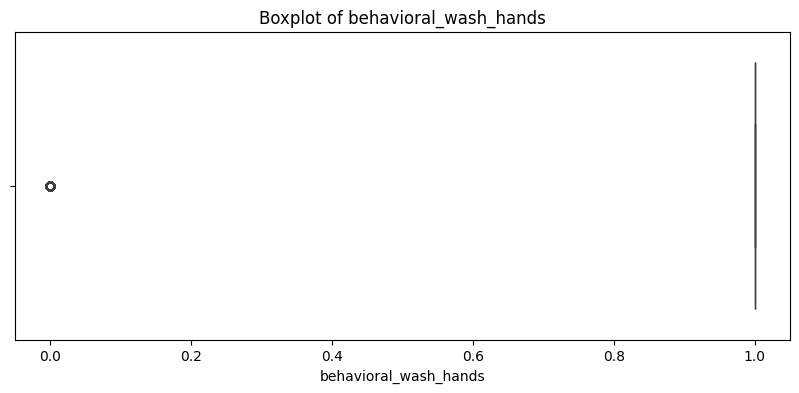

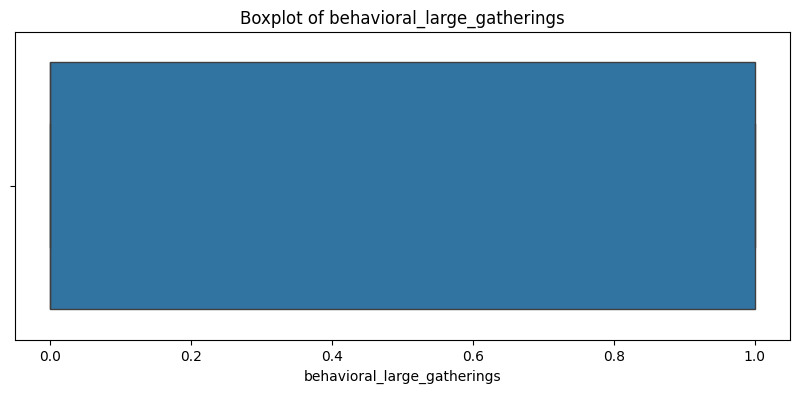

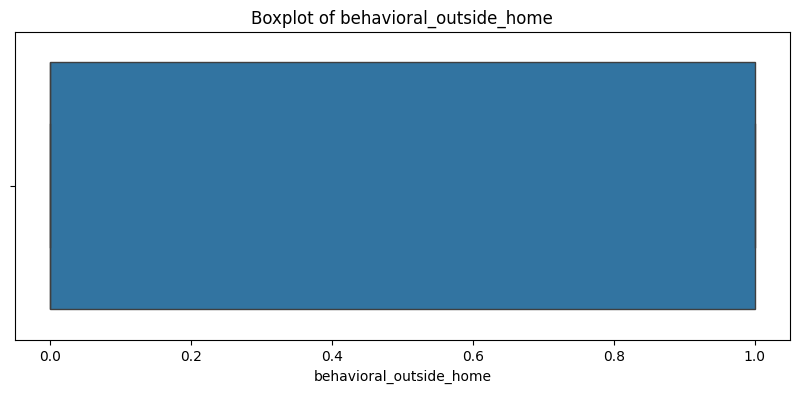

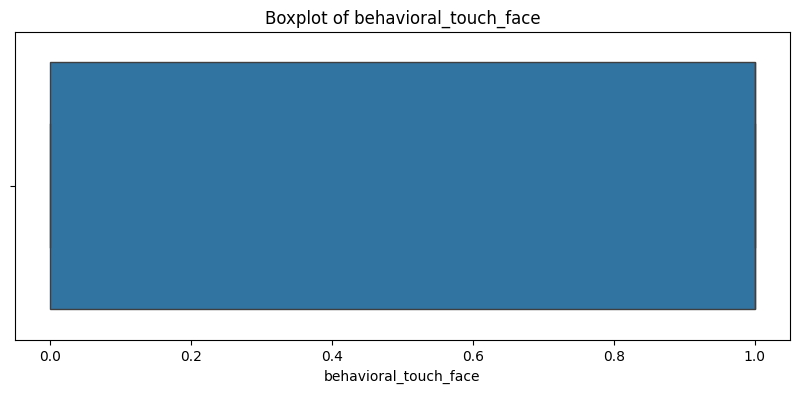

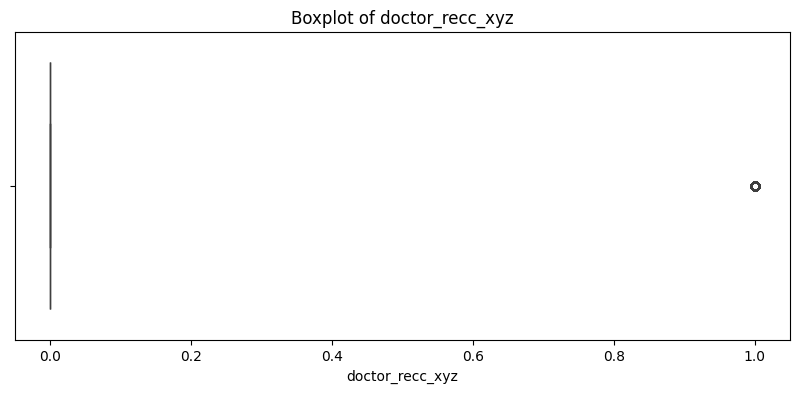

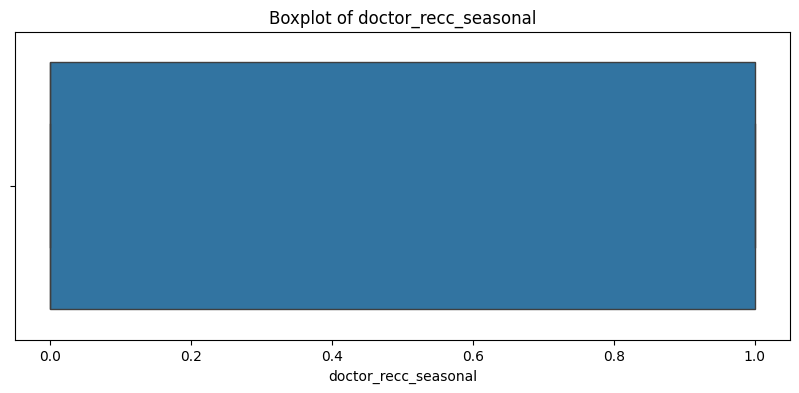

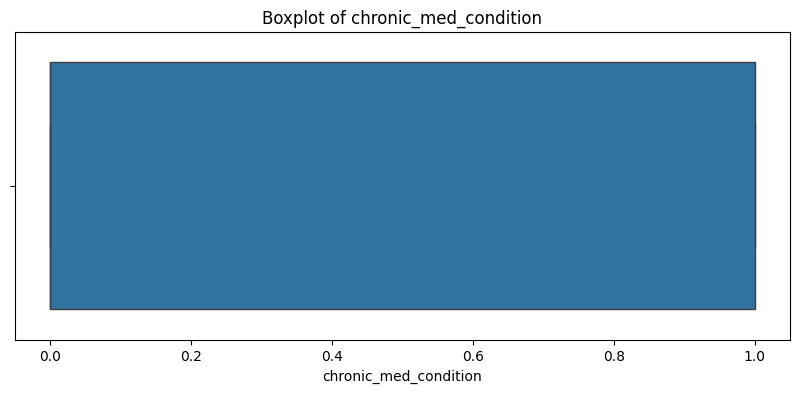

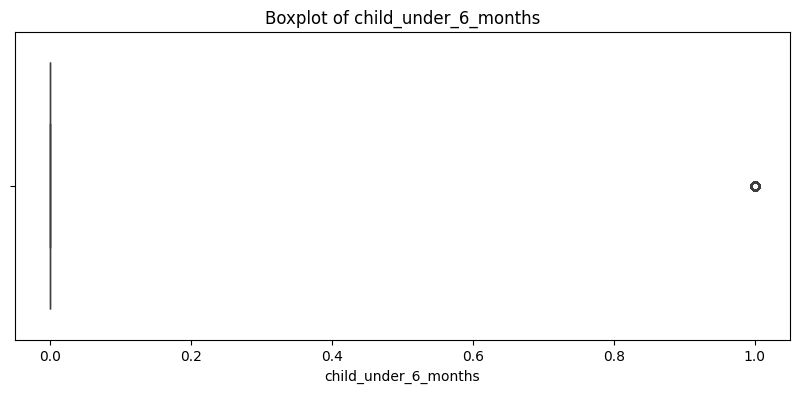

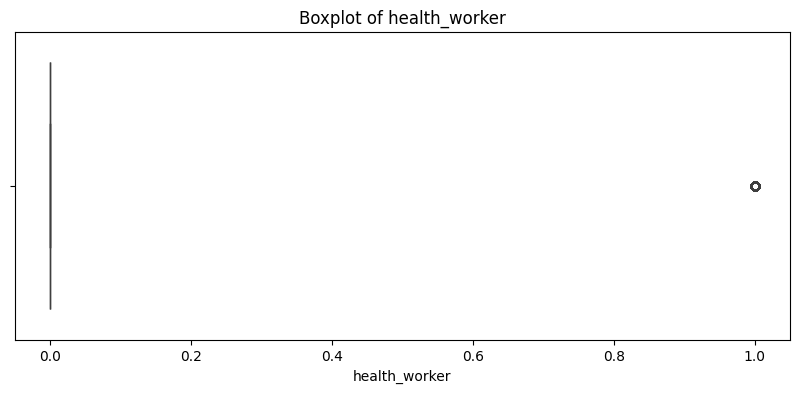

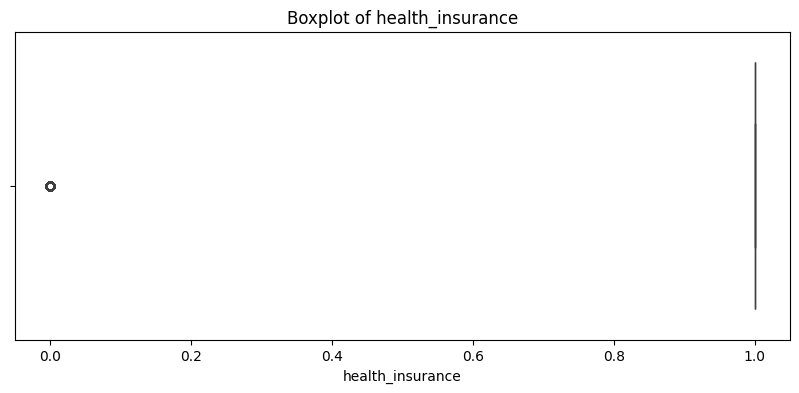

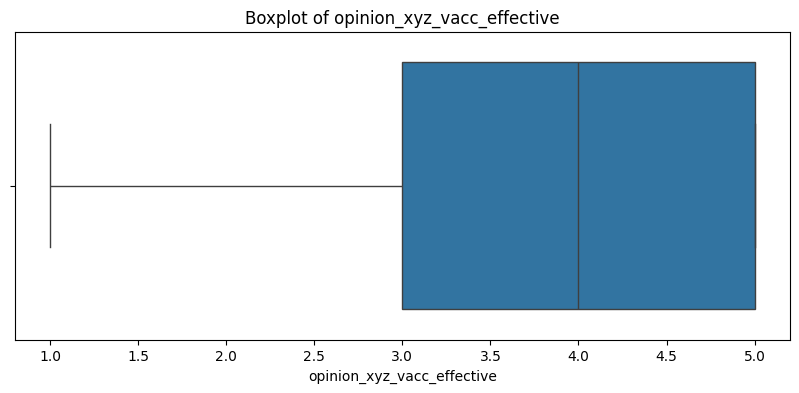

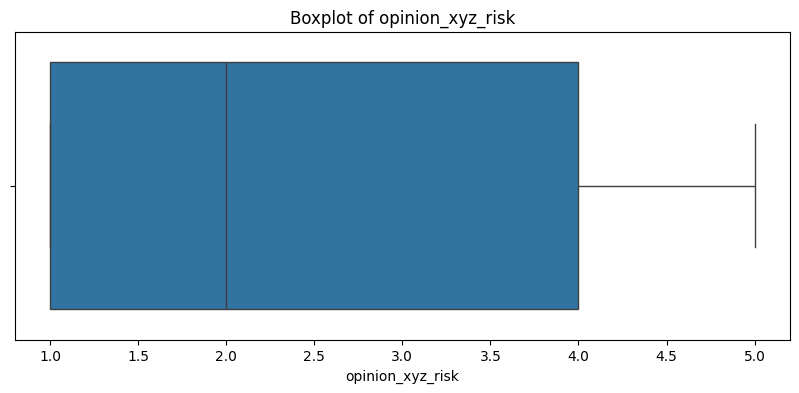

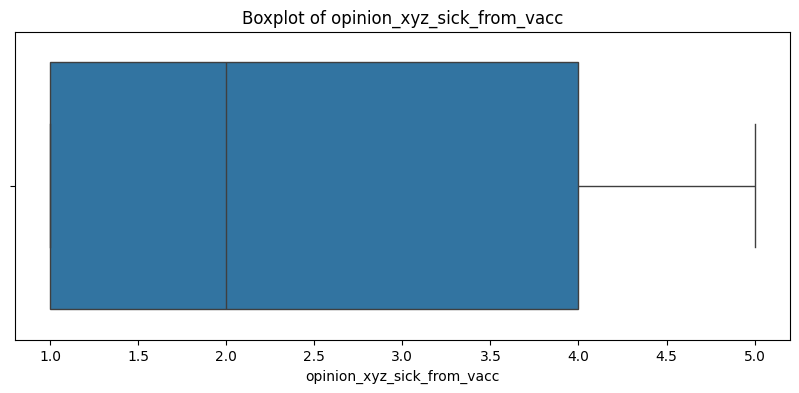

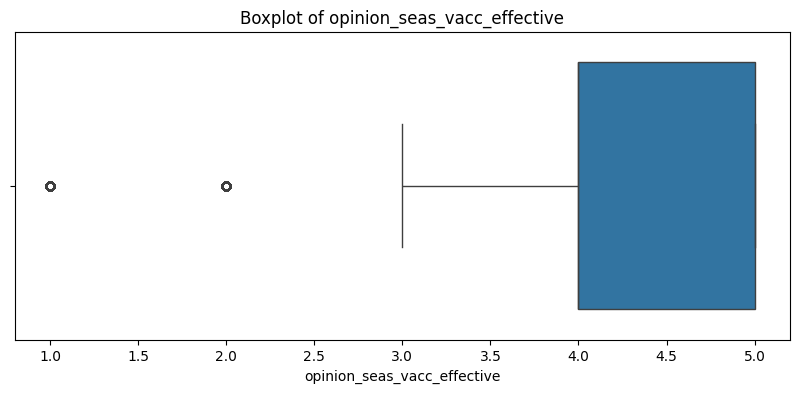

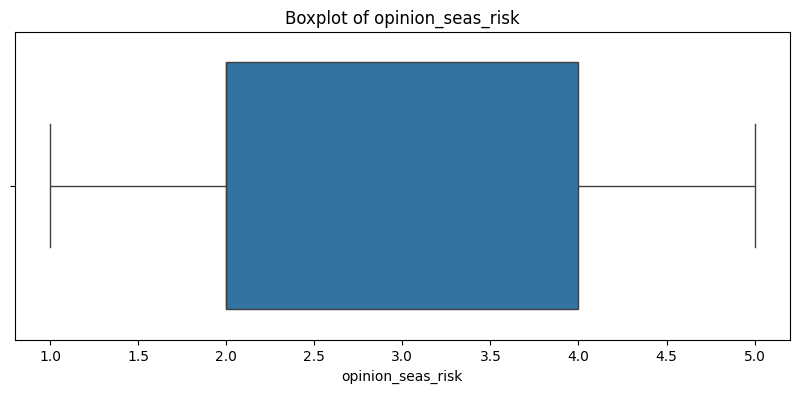

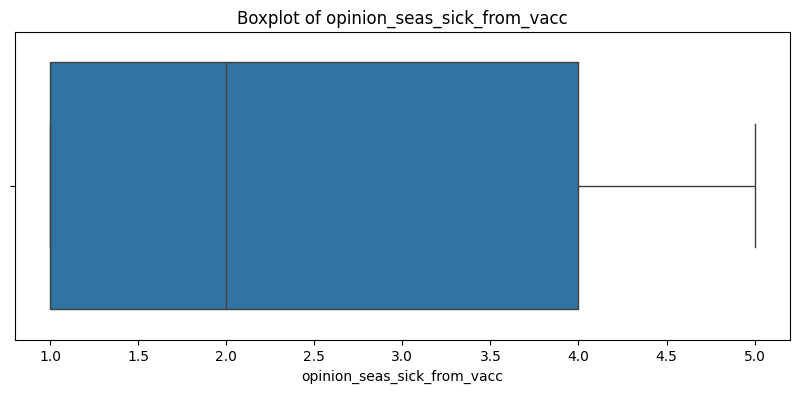

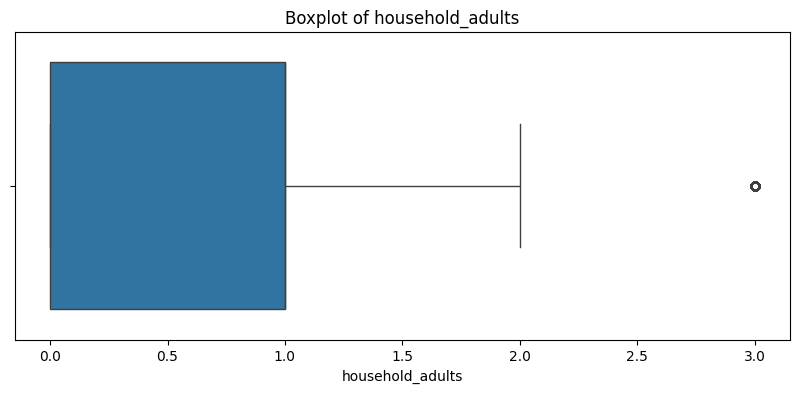

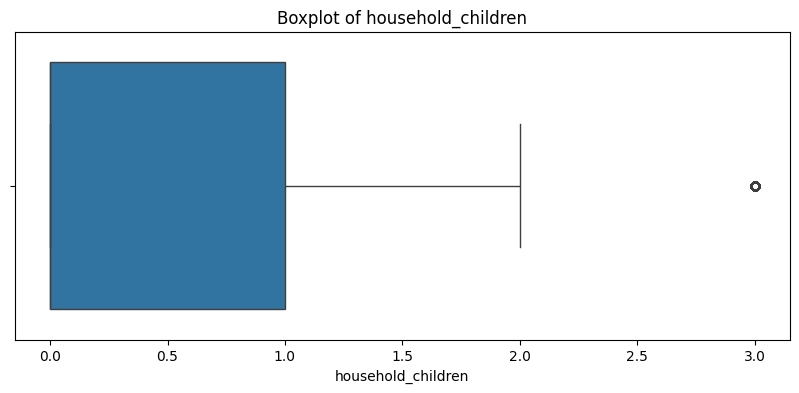

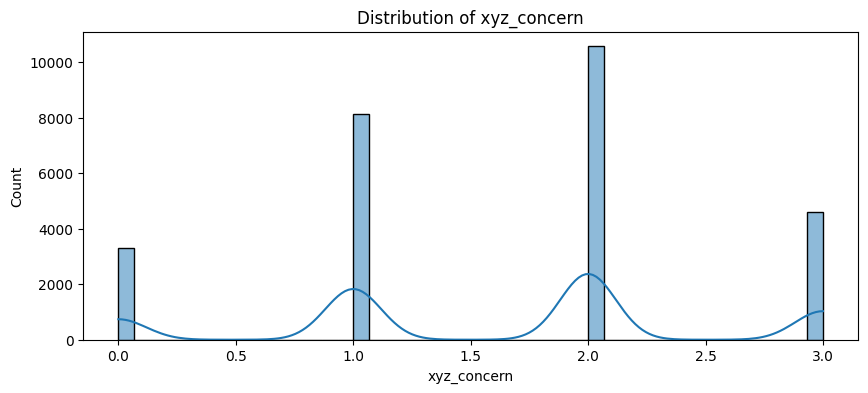

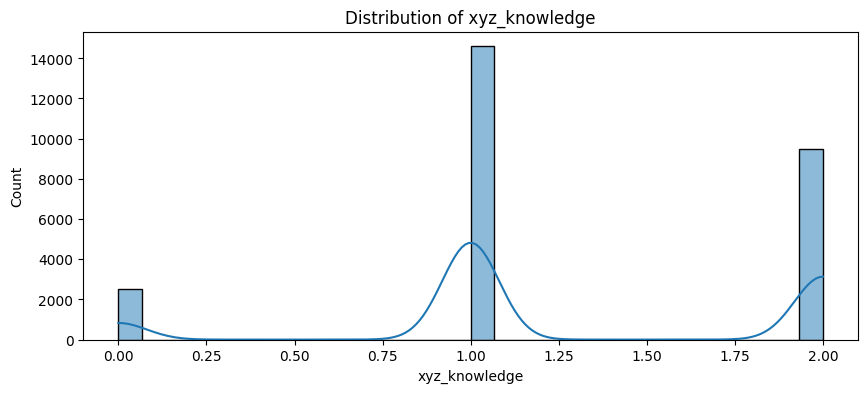

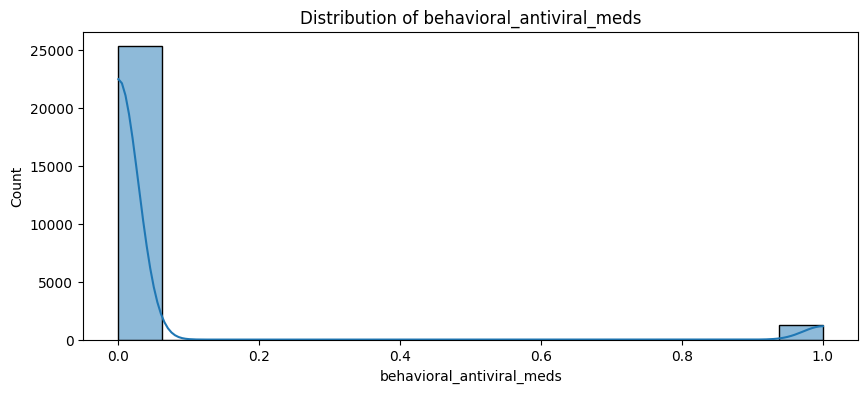

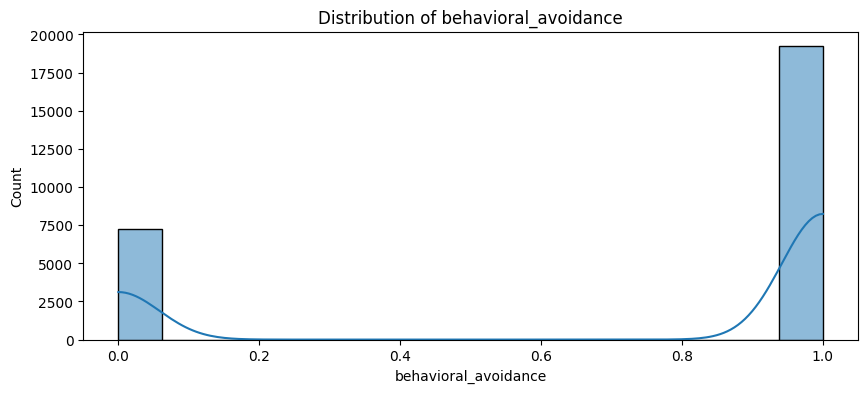

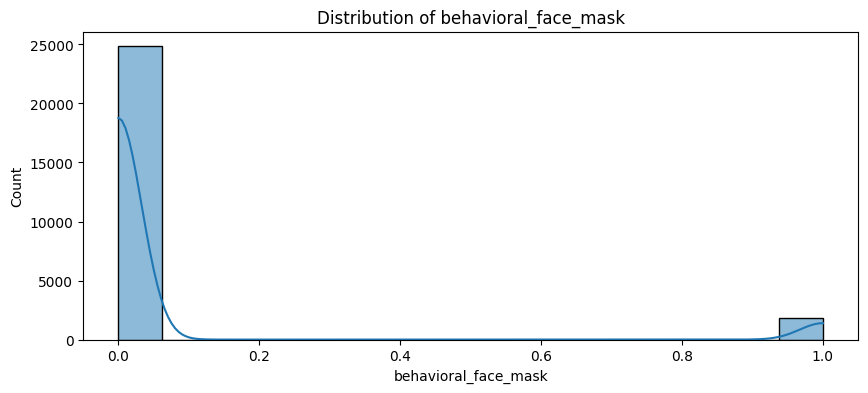

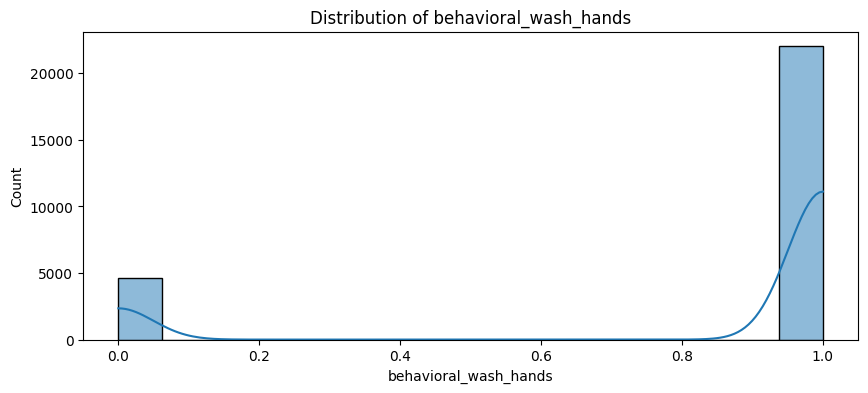

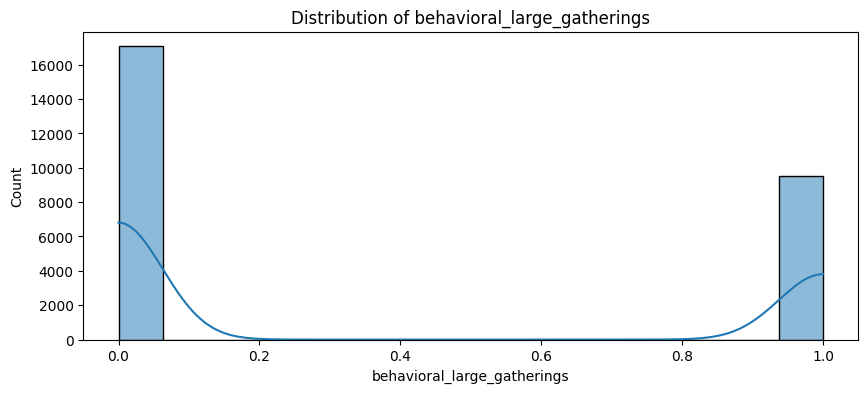

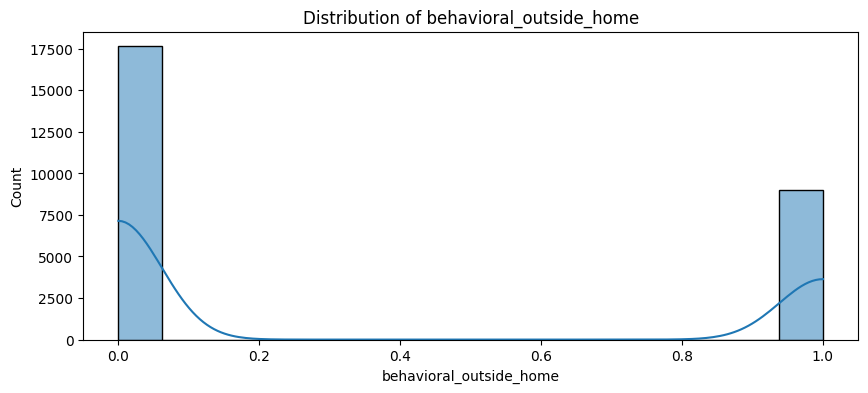

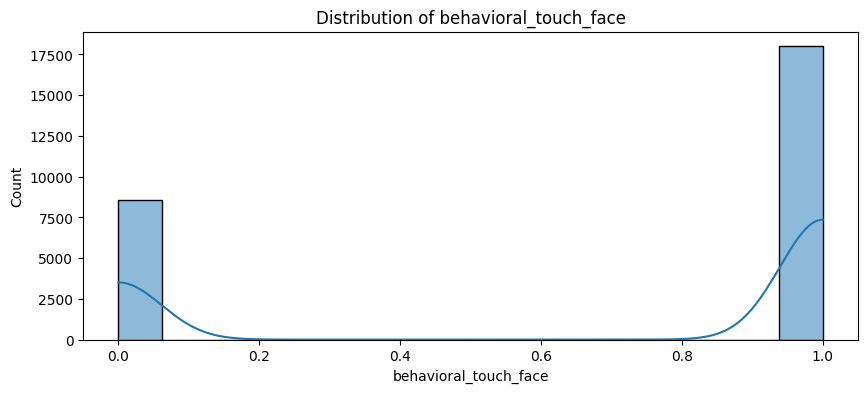

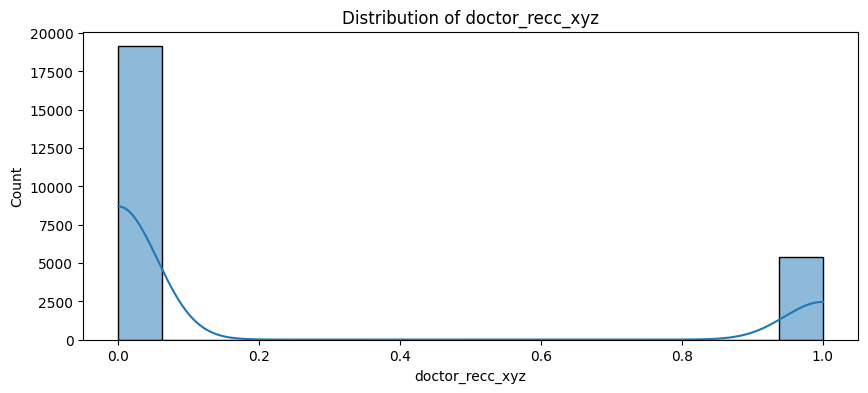

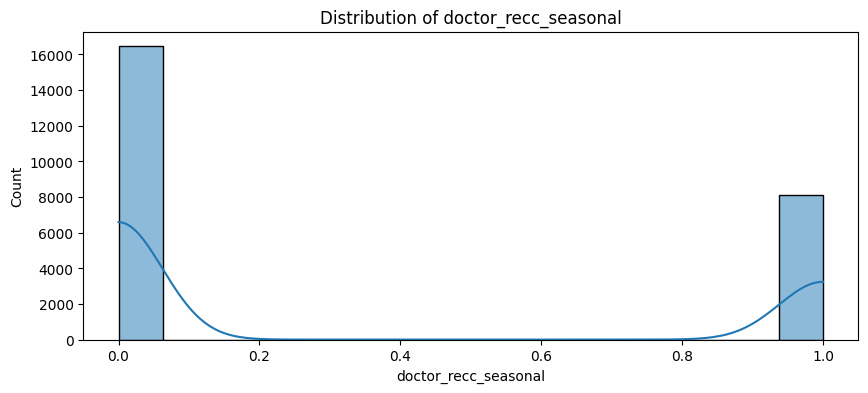

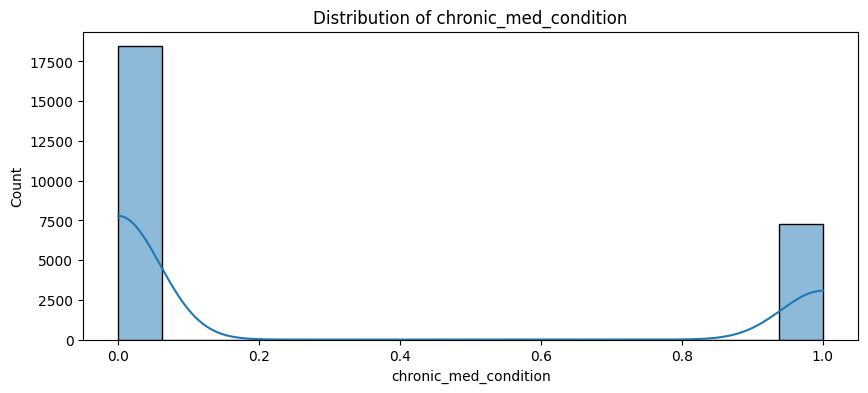

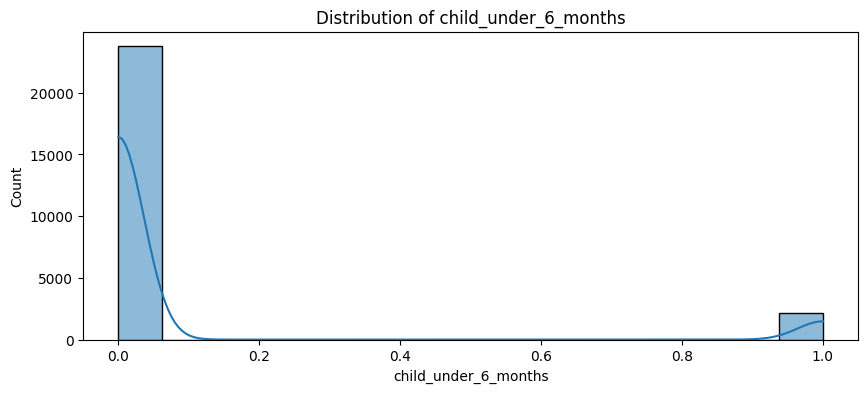

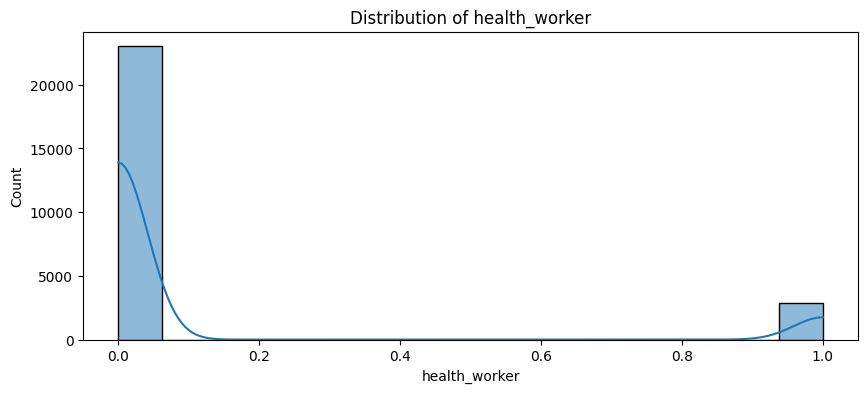

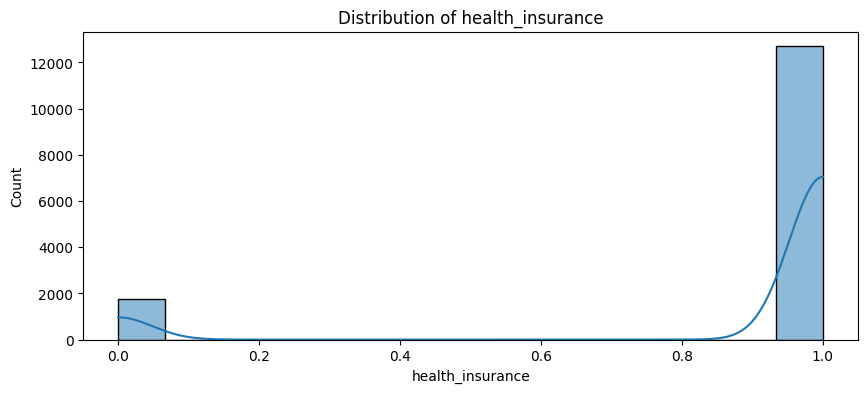

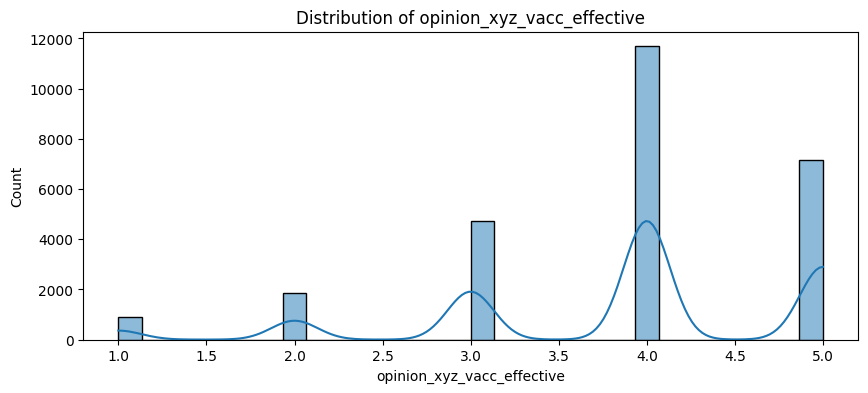

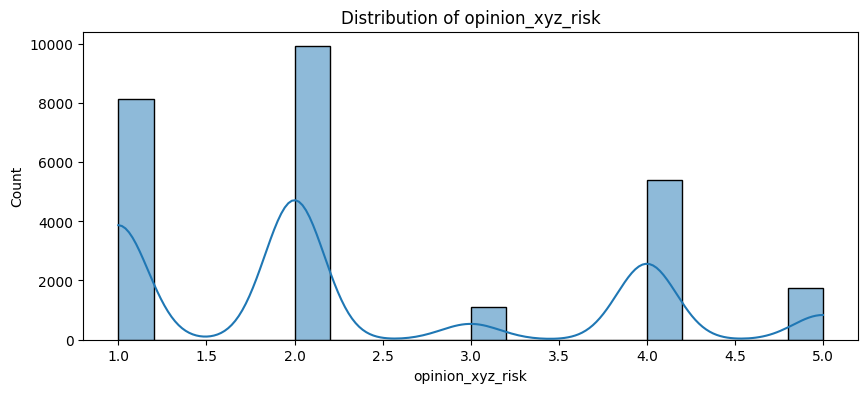

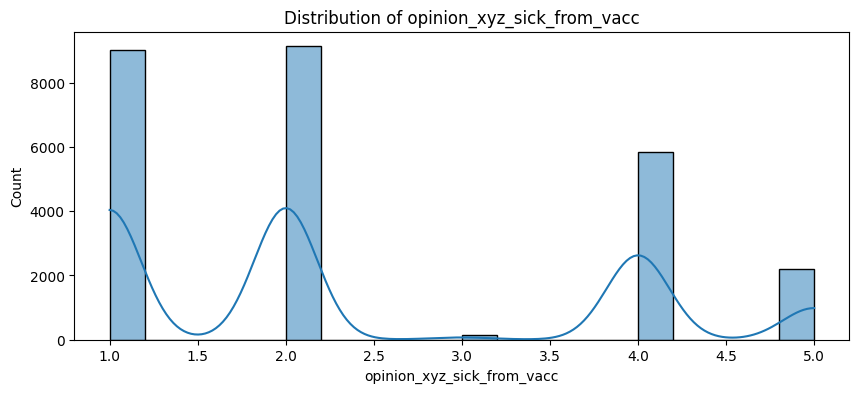

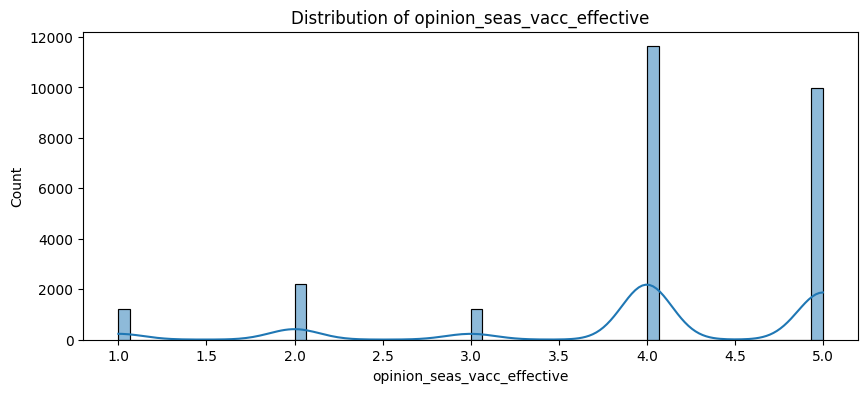

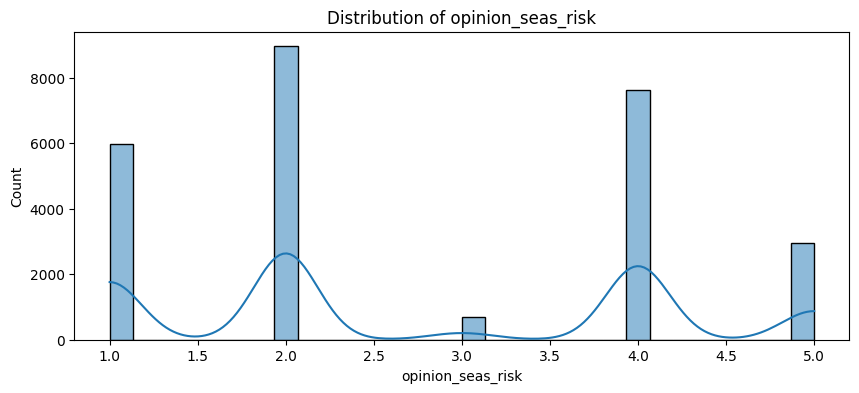

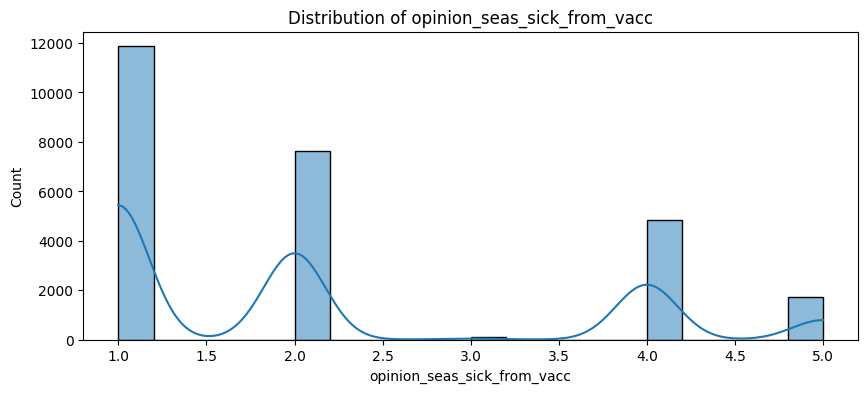

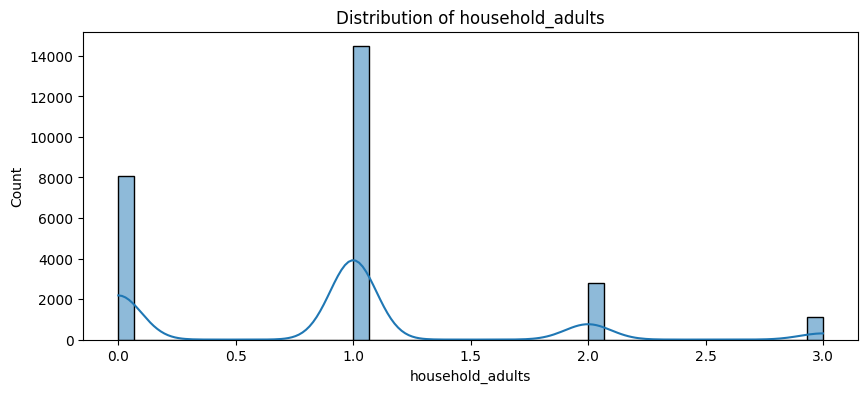

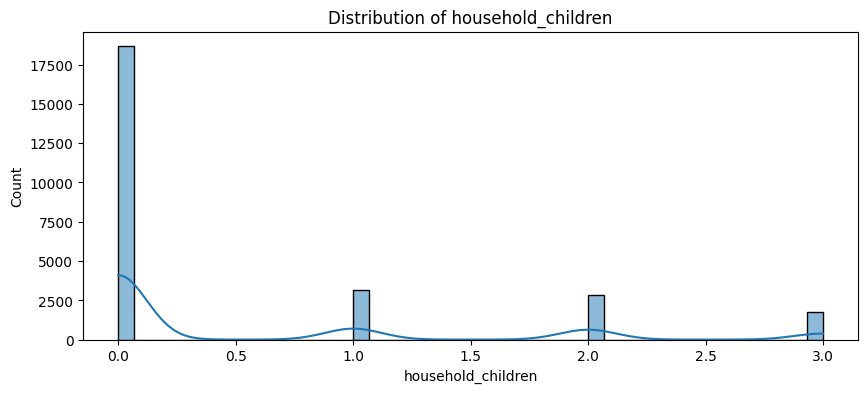

In [37]:
# Check for missing values
missing_values = X.isnull().sum()
print(f"Missing values in training set:\n{missing_values[missing_values > 0]}")

missing_values_test = X_test.isnull().sum()
print(f"Missing values in test set:\n{missing_values_test[missing_values_test > 0]}")

# Visualize outliers using boxplots
for column in X.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=X[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

# Visualize skewness
for column in X.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


In [38]:
# Check for missing values
missing_train = X.isnull().sum()
missing_test = X_test.isnull().sum()

print("Missing values in training set:\n", missing_train[missing_train > 0])
print("Missing values in test set:\n", missing_test[missing_test > 0])


Missing values in training set:
 xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
education                       1407
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
house

In [39]:
# Drop columns with more than 50% missing values
threshold = 0.5
cols_to_drop = missing_train[missing_train > threshold * len(X)].index
X.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)


In [40]:
# Identify skewed numerical features
from scipy.stats import skew

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
skewed_features = X[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features = skewed_features[abs(skewed_features) > 0.5]
print(f'Skewed features:\n{skewed_features}')


Skewed features:
behavioral_antiviral_meds      4.186267
behavioral_face_mask           3.401553
child_under_6_months           3.032832
health_worker                  2.461945
household_children             1.543815
doctor_recc_xyz                1.349659
chronic_med_condition          0.962041
opinion_seas_sick_from_vacc    0.919535
household_adults               0.786528
doctor_recc_seasonal           0.724353
behavioral_outside_home        0.688189
opinion_xyz_risk               0.672918
opinion_xyz_sick_from_vacc     0.651243
behavioral_large_gatherings    0.589489
behavioral_touch_face         -0.758312
opinion_xyz_vacc_effective    -0.902654
behavioral_avoidance          -1.011249
opinion_seas_vacc_effective   -1.315101
behavioral_wash_hands         -1.716283
health_insurance              -2.334666
dtype: float64


In [41]:
# Apply log transformation to skewed features
for feature in skewed_features.index:
    X[feature] = np.log1p(X[feature])
    X_test[feature] = np.log1p(X_test[feature])


In [42]:
# Separate numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Imputation transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [43]:
# Apply preprocessing to training and test data
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)


In [44]:
# Initialize the Random Forest model
rf_model_h1n1 = RandomForestClassifier(random_state=42)
rf_model_seasonal = RandomForestClassifier(random_state=42)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate the model for h1n1_vaccine
rf_model_h1n1.fit(X_preprocessed, y['xyz_vaccine'])
h1n1_scores = cross_val_score(rf_model_h1n1, X_preprocessed, y['xyz_vaccine'], cv=cv, scoring='roc_auc')
mean_h1n1_auc = np.mean(h1n1_scores)

# Train and evaluate the model for seasonal_vaccine
rf_model_seasonal.fit(X_preprocessed, y['seasonal_vaccine'])
seasonal_scores = cross_val_score(rf_model_seasonal, X_preprocessed, y['seasonal_vaccine'], cv=cv, scoring='roc_auc')
mean_seasonal_auc = np.mean(seasonal_scores)

mean_auc = np.mean([mean_h1n1_auc, mean_seasonal_auc])

print(f'Mean ROC AUC for h1n1_vaccine: {mean_h1n1_auc}')
print(f'Mean ROC AUC for seasonal_vaccine: {mean_seasonal_auc}')
print(f'Mean ROC AUC for both vaccines: {mean_auc}')


Mean ROC AUC for h1n1_vaccine: 0.8260199194160698
Mean ROC AUC for seasonal_vaccine: 0.8502830434080526
Mean ROC AUC for both vaccines: 0.8381514814120612


In [45]:
# Predict on the test set for h1n1_vaccine
y_pred_h1n1_test = rf_model_h1n1.predict_proba(X_test_preprocessed)[:, 1]

# Predict on the test set for seasonal_vaccine
y_pred_seasonal_test = rf_model_seasonal.predict_proba(X_test_preprocessed)[:, 1]

# Prepare submission file
submission = pd.DataFrame({
    'respondent_id': respondent_id,
    'xyz_vaccine': y_pred_h1n1_test,
    'seasonal_vaccine': y_pred_seasonal_test
})

# Save submission
submission.to_csv('submission.csv', index=False)
print(submission.head())


   respondent_id  xyz_vaccine  seasonal_vaccine
0          26707         0.14              0.32
1          26708         0.01              0.06
2          26709         0.56              0.82
3          26710         0.48              0.84
4          26711         0.26              0.48
